# Problem Statement: To analyze the data and predict the status of the animals when they leave the welfare center

The Animal Welfare Center (AWC) is one of the oldest animal shelters in the United States that provide care and shelter to over 15,000 animals each year. To boost its effort to help and care for animals in need, the organization makes available its accumulated data and statistics as part of its Open Data Initiative. The data contains information about the intake and discharge of animals entering the Animal Welfare Center from the beginning of October 2013 to the present day.


The AWC wants to make use of this data to help uncover useful insights that have the potential to save these animals’ lives. To make better decisions in the future regarding animal safety, AWC wants to analyze this data and predict the status of the animals when they leave the welfare center.

**Problem Type**- Multiclass classification

# **Steps taken-**

1) Required libraries

2) Loading datsets

3) Checking for Missing values and Imputation

4) Exploratory Data Analysis and Data Cleaning

5) Analysis, identification of patterns

6) Feature Engineering

7) Encoding the categorical data (one hot encoding and label encoding)

8) Modelling, tuning and prediction(Multiple iterations and subject to changes)

9) Submission of results

**EVALUATION METRIC: f1-score**

# **DATA PREPROCESSING**

# 1. Required libraries

I have used general libraries like pandas, malplotlib  for assembling, cleaning the data and most importantly libraries containing all the models

In [ ]:
#LOADING REQUIRED LIBRARIES
#Data Visualization libraries
import pandas as pd
import seaborn as sns
import numpy as np

#Machine learning classification model libraries
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot
%matplotlib inline


#Accuracy Check
from sklearn.model_selection import cross_val_score

#Encoders
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

#Scalers
from sklearn.preprocessing import StandardScaler

#Metrices import
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Importing train, test split library
from sklearn.model_selection import train_test_split

# Libraries to test model on different thresholds
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

#Metrices import
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
from numpy import loadtxt
from numpy import sort

#Import warnings
import warnings
warnings.filterwarnings("ignore")

#Importing custom packages
from sklearn.base import TransformerMixin

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

** Defining some customer functions for specific use**

In [ ]:
#Imputing the remaining missing variables
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, A, b=None):

        self.fill = pd.Series([A[c].value_counts().index[0]
            if A[c].dtype == np.dtype('O') else A[c].mean() for c in A],
            index=A.columns)

        return self

    def transform(self, A, b=None):
        return A.fillna(self.fill)

 # 2. Loading datasets

Lets have a quick look at the dataset:

In [ ]:
ml_dataset_train= pd.read_csv('/content/train.csv')
ml_dataset_test= pd.read_csv('/content/test.csv')

Text(0, 0.5, 'Frequency')

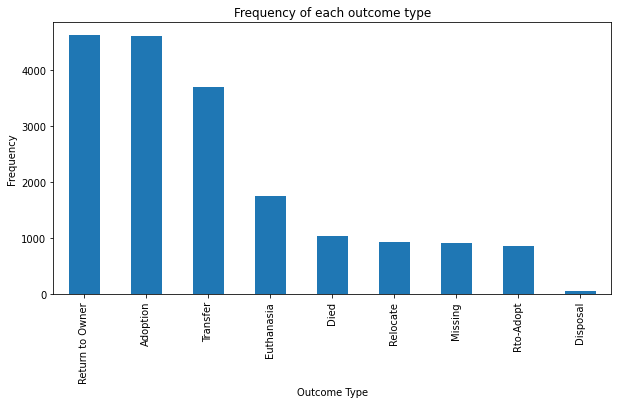

In [ ]:
#Drawing a count plot of dependent variable to check the biasness of prediction in data present
ax = ml_dataset_train['outcome_type'].value_counts().plot(kind='bar',figsize=(10,5),title="Frequency of each outcome type")
ax.set_xlabel("Outcome Type")
ax.set_ylabel("Frequency")

In [ ]:
print("Percent Class Distribution")
print(ml_dataset_train['outcome_type'].value_counts(normalize= True)*100)

Percent Class Distribution
Return to Owner    25.047325
Adoption           24.982422
Transfer           20.017308
Euthanasia          9.492130
Died                5.576289
Relocate            5.002975
Missing             4.975932
Rto-Adopt           4.602737
Disposal            0.302883
Name: outcome_type, dtype: float64


Data is highly biased. We need to select our train and test split carefully.

In [ ]:
#Loading the dataset
X= pd.read_csv('/content/train.csv')

# 3. Checking for Missing values and Imputation

In [ ]:
#Missing data check
total = X.isnull().sum().sort_values(ascending=False)
percent = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent * 100], axis=1, keys=['Total', 'Percent(%)'])
missing_data.head(5)

,Total,Percent(%)
outcome_datetime,4419,20.514368
sex_upon_outcome,2,0.009285
outcome_type,1,0.004642
age_upon_outcome,1,0.004642
sex_upon_intake,1,0.004642


Hence we will be dropping outcome_datetime as more than 15% that i selected as a threshold is missing.

** "outcome_datetime" needs to be dropped remaining two missing values we can impute**

In [ ]:
X = X.drop(['outcome_datetime'], axis  = 1)

In [ ]:
X = DataFrameImputer().fit_transform(pd.DataFrame(X))

In [ ]:
print('Missing value in training set:', X.isnull().sum().max())

Missing value in training set: 0


# 4. Exploratory Data Analysis and Data Cleaning

**Description of Numeric variable:**

In [ ]:
display(X.describe())

,dob_year,dob_month,count,age_upon_intake_(days),age_upon_intake_(years),intake_month,intake_year,intake_hour,intake_number,time_in_shelter_days,age_upon_outcome_(days),age_upon_outcome_(years),outcome_month,outcome_year,outcome_hour,outcome_number
count,21541.000000,21541.000000,21541.0,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000,21541.000000
mean,2011.234158,6.171348,1.0,991.105009,2.715356,6.478087,2014.083798,13.584819,1.150093,16.788162,1004.314253,2.751546,6.572238,2014.117549,14.593222,1.150093
std,3.118511,3.262349,0.0,1194.531647,3.272689,3.341591,0.907816,3.237088,0.489241,48.489048,1197.414179,3.280587,3.350983,0.909518,3.036132,0.489241
min,1992.000000,1.000000,1.0,0.000000,0.000000,1.000000,2013.000000,0.000000,1.000000,0.000694,0.000000,0.000000,1.000000,2013.000000,0.000000,1.000000
25%,2010.000000,4.000000,1.0,120.000000,0.328767,4.000000,2014.000000,11.000000,1.000000,1.022222,120.000000,0.328767,4.000000,2014.000000,13.000000,1.000000
50%,2012.000000,6.000000,1.0,365.000000,1.000000,6.000000,2014.000000,13.000000,1.000000,4.865278,365.000000,1.000000,7.000000,2014.000000,15.000000,1.000000
75%,2013.000000,9.000000,1.0,1460.000000,4.000000,10.000000,2014.000000,16.000000,1.000000,12.893750,1460.000000,4.000000,9.000000,2014.000000,17.000000,1.000000
max,2016.000000,12.000000,1.0,8030.000000,22.000000,12.000000,2018.000000,23.000000,8.000000,1606.194444,8030.000000,22.000000,12.000000,2018.000000,23.000000,8.000000


Couple of quick observations:

1. The variable **"count"** is having std 0 and min and max 1, implies it is a constant column having digit 1 hence we will be **dropping** this variable.

2. Also the statistics of **"intake_number"** and **"outcome_number"** looks similar hence lets quickly check and take a call.

In [ ]:
qck_check= pd.DataFrame(X.groupby(['intake_number', 'outcome_number']).size())
display(qck_check)

,,0
intake_number,outcome_number,
1.000000,1.000000,19128
1.150093,1.150093,1
2.000000,2.000000,1849
3.000000,3.000000,392
4.000000,4.000000,113
5.000000,5.000000,37
6.000000,6.000000,14
7.000000,7.000000,6
8.000000,8.000000,1


This implies **"intake_number"** and **"outcome_number"** are **duplicate columns** hence we will **drop** anyone of the variable, **lets drop "outcome_number"** .

Applying quick eda observations i.e. to drop outcome_number and count column:

In [ ]:
X = X.drop(['count', 'outcome_number'], axis = 1)
X.shape

(21541, 34)

**Description of Categorical variable**:

In [ ]:
X.describe(include = ['O'])

,animal_id_outcome,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_age_group,intake_datetime,intake_monthyear,intake_weekday,time_in_shelter,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_age_group,outcome_monthyear,outcome_weekday,outcome_type
count,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541,21541
unique,19122,45,4,1289,348,8,5,5,9,16064,54,7,12224,45,3830,5,9,55,7,9
top,A616444,1 year,Dog,Domestic Shorthair Mix,Black/White,Normal,Stray,Intact Male,"(-0.025, 2.5]",2014-07-09 12:58:00,2014-05,Saturday,0 days 00:19:00.000000000,1 year,2014-04-21 00:00:00,Neutered Male,"(-0.025, 2.5]",2014-07,Saturday,Adoption
freq,8,3311,13386,5335,2219,18734,14417,6098,13931,63,1957,3327,33,3345,79,8186,13867,2073,3484,5417


In [ ]:
X[X['animal_id_outcome']=='A721033']

,animal_id_outcome,dob_year,dob_month,age_upon_intake,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),age_upon_intake_(years),age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days,age_upon_outcome,date_of_birth,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type


Looking at the above dataset it looks like **"animal_id_outcome"** is not unique. Maybe same animals were repeated brought to the shelter for some or the other reasons. Anyways we will be dropping it as it makes very little or no help in our model predictions.

In [ ]:
X = X.drop(['animal_id_outcome'], axis = 1)

# 5. Analysis, identification of patterns

Next step would be to analyse, identify and explore the data to take actions based upon the understanding.

**A. Few quick points to be noted:**
1. age_upon_intake_(days), age_upon_intake_(years)/age_group are extracted from age_upon_intake and there is no point using all of them. Hence we will keep age_upon_intake_(days) as it is more specific. Hence **dropping age_upon_intake**, **age_upon_intake_(years), age_upon_intake_age_group** similary **dropping age_upon_outcome, age_upon_outcome_(years), age_upon_outcome_age_group

2. dob_year, dob_month is extracted from date_of_birth hence will be using dob_year to be more specific and ** dropping date_of_birth ** and **dob_month**  as they are useless for our case.
3. According to my research once the animal or pet is surrendender by owner the animal/pet cannot be or vary rarely returned back to owner again with some conditions hence **intake_type** is an **important predictor**.
4. animal_type and breed type is specific to the category of animal hence are correlated. We need to take a call whether to use both or use one of them according to the varibale importance curve
5. time_in_shelter_(days) is derived from time_in_shelter hence will be **dropping time_in_shelter** and keeping **time_in_shelter_(days)**


In [ ]:
X = X.drop(['age_upon_intake', 'age_upon_intake_(years)', 'age_upon_intake_age_group', 'age_upon_outcome', 'age_upon_outcome_(years)', 'age_upon_outcome_age_group', 'date_of_birth','dob_month', 'time_in_shelter'], axis = 1)

**B. Checking categorical variables correlation with outcome_type **

In [ ]:
#Checking animal_type with outcome_type
X.groupby(["animal_type", 'outcome_type']).size()

animal_type  outcome_type   
Bird         Adoption              7
             Died                  6
             Euthanasia            8
             Missing               1
             Relocate              3
             Rto-Adopt             3
             Transfer             22
Cat          Adoption           1899
             Died                504
             Disposal              1
             Euthanasia          410
             Missing             452
             Relocate            455
             Return to Owner     456
             Rto-Adopt           403
             Transfer           2400
Dog          Adoption           3501
             Died                670
             Euthanasia          765
             Missing             644
             Relocate            645
             Return to Owner    4619
             Rto-Adopt           601
             Transfer           1941
Other        Adoption             10
             Died                 31
         

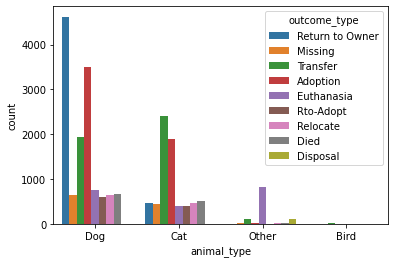

In [ ]:
sns.countplot(x="animal_type", hue="outcome_type", data= X)

In [ ]:
X_Bird = X[X['animal_type']=='Bird']

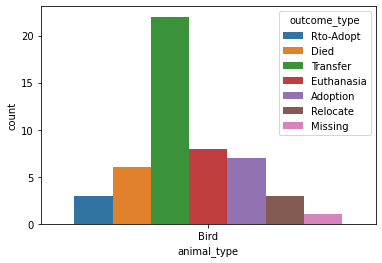

In [ ]:
sns.countplot(x= 'animal_type', hue="outcome_type", data= X_Bird)

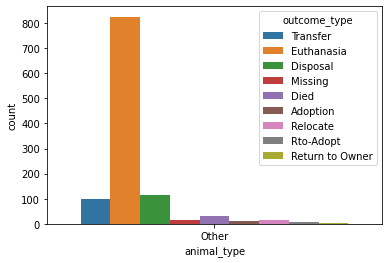

In [ ]:
X_Other= X[X['animal_type']=='Other']
sns.countplot(x= 'animal_type', hue="outcome_type", data= X_Other)

In [ ]:
#Checking animal_type with outcome_type
X.groupby(["breed", 'outcome_type']).size().head(20)

breed                        outcome_type   
Abyssinian Mix               Adoption           2
                             Died               1
Affenpinscher Mix            Adoption           2
                             Missing            1
                             Return to Owner    1
Afghan Hound Mix             Return to Owner    1
Airedale Terrier             Transfer           1
Airedale Terrier Mix         Return to Owner    2
Akita                        Adoption           1
                             Euthanasia         1
Akita Mix                    Adoption           2
                             Died               1
                             Missing            1
                             Relocate           1
                             Return to Owner    6
                             Transfer           1
Akita/Australian Cattle Dog  Adoption           1
                             Relocate           1
Akita/Border Collie          Adoption           1
Akita

Hence we get this insights that dogs are mostly adopted and returned back to owner, cats are either mostly been adopted or transfered, on the other hand bird are either adopted or transfered and are rarely "returned back to owner"(which has high occurence in the dataset). Last other animals are mostly euthonised or transfered.

**NOTE** We will be holding color variable as it is as there more than 400 unique colors and will be checking later by variable importance plot.

In [ ]:
#Checking intake-condition 
X.groupby(['intake_type','outcome_type']).size()

intake_type         outcome_type   
Euthanasia Request  Adoption              8
                    Died                  3
                    Euthanasia          113
                    Missing               1
                    Relocate              1
                    Return to Owner       2
                    Transfer              6
Owner Surrender     Adoption           1643
                    Died                309
                    Euthanasia          314
                    Missing             297
                    Relocate            278
                    Return to Owner     301
                    Rto-Adopt           255
                    Transfer            949
Public Assist       Adoption            127
                    Died                 31
                    Disposal              1
                    Euthanasia          105
                    Missing              33
                    Relocate             40
                    Return to Owner    1

Hence this along with intake_condition can be useful for model to help predict minority of the dependent variable such as died, disposal, missing and relocate hence our hypothesis of these variable to be important for model is proving true.

In [ ]:
X.groupby(['sex_upon_intake','sex_upon_outcome', 'outcome_type']).size()

sex_upon_intake  sex_upon_outcome  outcome_type   
Intact Female    Intact Female     Adoption             95
                                   Died                163
                                   Euthanasia          285
                                   Missing             146
                                   Relocate            137
                                   Return to Owner     231
                                   Rto-Adopt           131
                                   Transfer           1237
                 Spayed Female     Adoption           1671
                                   Died                219
                                   Euthanasia           22
                                   Missing             248
                                   Relocate            228
                                   Return to Owner     296
                                   Rto-Adopt           211
                                   Transfer            314
Intac

Hence we will be keeping on i.e for now as we can clearly see Intact male/female who were first intact and later neutered/spayed have more chances of adoption about 20 folds. hence this can prove to be an important variable.

One more observation is that we will be dropping intake_datetime as we already have intake month, year

In [ ]:
X['intake_day'] = pd.DatetimeIndex(X['intake_datetime']).day

**Note: The above is a new feature that is generated**

In [ ]:
X = X.drop(['intake_datetime'], axis = 1)

**Feature modification of intake/outcome year month:**

In [ ]:
X['intake_monthyear'] = X['intake_year'] * 100 + X['intake_month']
X['outcome_monthyear'] = X['outcome_year']* 100 + X['outcome_month']
X

,dob_year,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(days),outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type,intake_day
0,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,3650,12.000000,2017.000000,201712.000000,Thursday,14.000000,1.000000,0.588194,Neutered Male,3650.000000,12.000000,2017.000000,201712.000000,Thursday,0.000000,Return to Owner,7
1,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2555,12.000000,2014.000000,201412.000000,Friday,10.000000,2.000000,1.259722,Neutered Male,2555.000000,12.000000,2014.000000,201412.000000,Saturday,16.000000,Return to Owner,19
2,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2190,3.000000,2014.000000,201403.000000,Friday,14.000000,3.000000,1.113889,Neutered Male,2190.000000,3.000000,2014.000000,201403.000000,Saturday,17.000000,Return to Owner,7
3,2004,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,3650,4.000000,2014.000000,201404.000000,Wednesday,15.000000,1.000000,4.970139,Neutered Male,3650.000000,4.000000,2014.000000,201404.000000,Monday,15.000000,Missing,2
4,1997,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,5840,11.000000,2013.000000,201311.000000,Saturday,9.000000,1.000000,0.119444,Neutered Male,5840.000000,11.000000,2013.000000,201311.000000,Saturday,11.000000,Return to Owner,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,2009,Dog,Toy Poodle Mix,Apricot,Normal,Public Assist,Neutered Male,1825,9.000000,2014.000000,201409.000000,Saturday,11.000000,1.000000,9.070833,Neutered Male,1825.000000,9.000000,2014.000000,201409.000000,Monday,13.000000,Return to Owner,13
21537,2012,Dog,Boxer Mix,Fawn/White,Normal,Owner Surrender,Intact Male,730,9.000000,2014.000000,201409.000000,Thursday,14.000000,1.000000,1.142361,Neutered Male,730.000000,9.000000,2014.000000,201409.000000,Friday,17.000000,Died,25
21538,2014,Dog,Labrador Retriever Mix,Brown,Normal,Stray,Spayed Female,730,5.000000,2017.000000,201705.000000,Thursday,11.000000,1.000000,0.143750,Spayed Female,730.000000,5.000000,2017.000000,201705.000000,Thursday,14.000000,Return to Owner,4
21539,2014,Dog,Labrador Retriever Mix,Brown,Normal,Stray,Intact Female,60,9.000000,2014.000000,201409.000000,Saturday,11.000000,2.000000,4.279861,Spayed Female,60.000000,9.000000,2014.000000,201409.000000,Wednesday,18.000000,Missing,13


My hypothesis regarding outcomeWeekdays should be that there will more adoptions on sundays and saturdays as people have holiday and they can visit the facility for official adoption. I dont think that intakeWeekdays will have much significance to our prediction, we will check and discard it later if required.

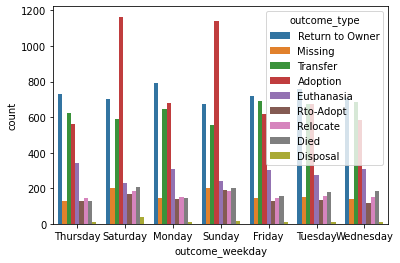

In [ ]:
sns.countplot(x= 'outcome_weekday', hue="outcome_type", data= X)

The results are as expected there are relatively more adoptions on saturday and sundays. Hence we will keep these variables for now and test it in our variable importance plot.

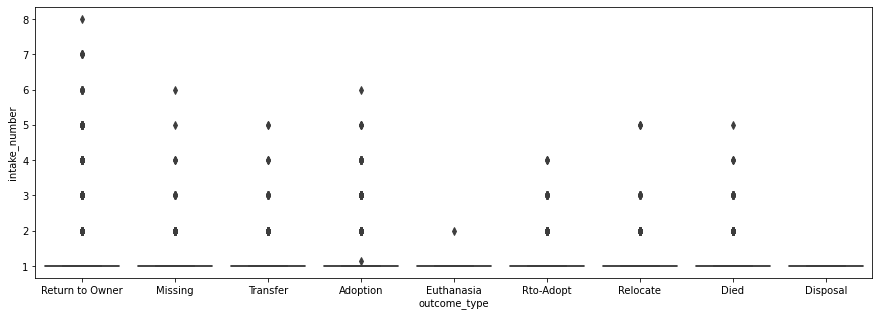

In [ ]:
pyplot.figure(figsize=(15,5))
sns.boxplot(X['outcome_type'], X['intake_number'])

Higher number of intake_number has more chances of returning to owner, adoption and missing. Hence an important variable

Lets have a quick check on variable importance and model performance so that we can tweak it accordingly.

** Converting the data into training and validation set **

In [ ]:
X

,dob_year,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(days),outcome_month,outcome_year,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type,intake_day
0,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Stray,Neutered Male,3650,12.000000,2017.000000,201712.000000,Thursday,14.000000,1.000000,0.588194,Neutered Male,3650.000000,12.000000,2017.000000,201712.000000,Thursday,0.000000,Return to Owner,7
1,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2555,12.000000,2014.000000,201412.000000,Friday,10.000000,2.000000,1.259722,Neutered Male,2555.000000,12.000000,2014.000000,201412.000000,Saturday,16.000000,Return to Owner,19
2,2007,Dog,Spinone Italiano Mix,Yellow/White,Normal,Public Assist,Neutered Male,2190,3.000000,2014.000000,201403.000000,Friday,14.000000,3.000000,1.113889,Neutered Male,2190.000000,3.000000,2014.000000,201403.000000,Saturday,17.000000,Return to Owner,7
3,2004,Dog,Dachshund,Tricolor,Normal,Owner Surrender,Neutered Male,3650,4.000000,2014.000000,201404.000000,Wednesday,15.000000,1.000000,4.970139,Neutered Male,3650.000000,4.000000,2014.000000,201404.000000,Monday,15.000000,Missing,2
4,1997,Dog,Shetland Sheepdog,Brown/White,Injured,Public Assist,Neutered Male,5840,11.000000,2013.000000,201311.000000,Saturday,9.000000,1.000000,0.119444,Neutered Male,5840.000000,11.000000,2013.000000,201311.000000,Saturday,11.000000,Return to Owner,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,2009,Dog,Toy Poodle Mix,Apricot,Normal,Public Assist,Neutered Male,1825,9.000000,2014.000000,201409.000000,Saturday,11.000000,1.000000,9.070833,Neutered Male,1825.000000,9.000000,2014.000000,201409.000000,Monday,13.000000,Return to Owner,13
21537,2012,Dog,Boxer Mix,Fawn/White,Normal,Owner Surrender,Intact Male,730,9.000000,2014.000000,201409.000000,Thursday,14.000000,1.000000,1.142361,Neutered Male,730.000000,9.000000,2014.000000,201409.000000,Friday,17.000000,Died,25
21538,2014,Dog,Labrador Retriever Mix,Brown,Normal,Stray,Spayed Female,730,5.000000,2017.000000,201705.000000,Thursday,11.000000,1.000000,0.143750,Spayed Female,730.000000,5.000000,2017.000000,201705.000000,Thursday,14.000000,Return to Owner,4
21539,2014,Dog,Labrador Retriever Mix,Brown,Normal,Stray,Intact Female,60,9.000000,2014.000000,201409.000000,Saturday,11.000000,2.000000,4.279861,Spayed Female,60.000000,9.000000,2014.000000,201409.000000,Wednesday,18.000000,Missing,13


# Feature encoding(initial iteration)

In [ ]:
X_check = X.copy()

In [ ]:
def onehotdataframe(X_check):    
    one_hot_animal_type=pd.get_dummies(X_check.animal_type)

    one_hot_intake_condition = pd.get_dummies(X_check.intake_condition)
    one_hot_intake_condition.columns = [str(col) + '_intake' for col in one_hot_intake_condition.columns]

    one_hot_intake_type = pd.get_dummies(X_check.intake_type)
    one_hot_intake_type.columns = [str(col) + '_intake' for col in one_hot_intake_type.columns]

    one_hot_sex_upon_intake = pd.get_dummies(X_check.sex_upon_intake)
    one_hot_sex_upon_intake.columns = [str(col) + '_intake' for col in one_hot_sex_upon_intake.columns]

    one_hot_intake_weekday = pd.get_dummies(X_check.intake_weekday)
    one_hot_intake_weekday.columns = [str(col) + '_intake' for col in one_hot_intake_weekday.columns]

    one_hot_sex_upon_outcome = pd.get_dummies(X_check.sex_upon_outcome)
    one_hot_sex_upon_outcome.columns = [str(col) + '_outcome' for col in one_hot_sex_upon_outcome.columns]

    one_hot_outcome_weekday = pd.get_dummies(X_check.outcome_weekday)
    one_hot_outcome_weekday.columns = [str(col) + '_outcome' for col in one_hot_outcome_weekday.columns]     

    X_check = X_check.drop(['animal_type','intake_type', 'intake_condition', 'sex_upon_intake', 'intake_weekday', 'sex_upon_outcome', 'outcome_weekday'], axis = 1) 

    #Merging one hot encoded features with our dataset 'data' 
    X_check=pd.concat([X_check, one_hot_animal_type,one_hot_intake_condition,one_hot_intake_type,one_hot_sex_upon_intake,one_hot_intake_weekday,one_hot_sex_upon_outcome,one_hot_outcome_weekday],axis=1)  
    
    return(X_check)

In [ ]:
X_check = onehotdataframe(X_check)
X_check['outcome_type'] = X_check['outcome_type'].map({'Adoption' : 8, 'Transfer': 7, 'Return to Owner' : 6, 'Euthanasia' : 5, 'Died' : 4, 'Missing' : 3, 'Relocate' : 2, 'Rto-Adopt' : 1, 'Disposal' : 0}) 
y_check = X_check['outcome_type']
X_check= X_check.drop(['outcome_type'], axis = 1)

** Applying label encoding: **

In [ ]:
le1= LabelEncoder()
le2= LabelEncoder()

le1.fit(X_check['breed'])
#print(le1.classes_)

X_check['breed'] = le1.transform(X_check['breed'])

le2.fit(X_check['color'])
#print(le2.classes_)

X_check['color'] = le2.transform(X_check['color'])

In [ ]:
# Splitting the dataset into the Training set and Test set.
X_train_check, X_val_check, y_train_check, y_val_check = train_test_split(X_check, y_check, test_size = 0.2, random_state = 20)
#Split is 80%-20% for testing. Here X_test~Validation set.


print(X_train_check.shape, X_val_check.shape, y_train_check.shape, y_val_check.shape)

(17232, 57) (4309, 57) (17232,) (4309,)


Text(0, 0.5, 'Frequency')

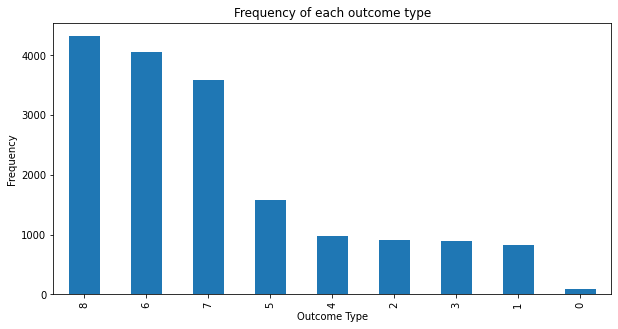

In [ ]:
#Drawing a count plot of dependent variable to check the biasness of prediction in data present
bx = pd.DataFrame(y_train_check)['outcome_type'].value_counts().plot(kind='bar',figsize=(10,5),title="Frequency of each outcome type")
bx.set_xlabel("Outcome Type")
bx.set_ylabel("Frequency")

In [ ]:
print("Class distribution count")
print(pd.DataFrame(y_train_check)['outcome_type'].value_counts())
print("Class distribution percent(%)")
print(pd.DataFrame(y_val_check)['outcome_type'].value_counts(normalize = True)*100)

Class distribution count
8    4326
6    4058
7    3577
5    1584
4     972
2     902
3     900
1     822
0      91
Name: outcome_type, dtype: int64
Class distribution percent(%)
8    25.319100
6    23.717800
7    20.584822
5     9.839870
4     5.546531
2     4.989557
3     4.943142
1     4.455790
0     0.603388
Name: outcome_type, dtype: float64


This implies we are good to go with this training data set as it is showing same stats as that of combined dataset.

# Modelling(Initial iterations)

** Starting with lightgbm test**

** Test 1**

In [ ]:
import lightgbm as lgb

In [ ]:
check_train_data=lgb.Dataset(X_train_check,label=y_train_check)

In [ ]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':9,
    'metric': 'multi_logloss',
    'learning_rate': 0.0023,
    'max_depth': 7,
    'num_leaves': 16,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.6,
    'bagging_freq': 17 }

In [ ]:
lgb_cv = lgb.cv(params, check_train_data, num_boost_round=10000, nfold=3, shuffle=True, stratified=True, verbose_eval=20, early_stopping_rounds=100)

nround = lgb_cv['multi_logloss-mean'].index(np.min(lgb_cv['multi_logloss-mean']))
print(nround)

model = lgb.train(params, check_train_data, num_boost_round=nround)

[20]	cv_agg's multi_logloss: 1.84723 + 0.000358216
[40]	cv_agg's multi_logloss: 1.82194 + 0.000801167
[60]	cv_agg's multi_logloss: 1.79778 + 0.00112112
[80]	cv_agg's multi_logloss: 1.77584 + 0.0013809
[100]	cv_agg's multi_logloss: 1.75496 + 0.00161067
[120]	cv_agg's multi_logloss: 1.73527 + 0.00184334
[140]	cv_agg's multi_logloss: 1.71571 + 0.00216524
[160]	cv_agg's multi_logloss: 1.69892 + 0.00243238
[180]	cv_agg's multi_logloss: 1.68146 + 0.00265688
[200]	cv_agg's multi_logloss: 1.66555 + 0.0029562
[220]	cv_agg's multi_logloss: 1.65127 + 0.00320113
[240]	cv_agg's multi_logloss: 1.63716 + 0.0034171
[260]	cv_agg's multi_logloss: 1.62378 + 0.00363596
[280]	cv_agg's multi_logloss: 1.61165 + 0.00376256
[300]	cv_agg's multi_logloss: 1.59942 + 0.00402511
[320]	cv_agg's multi_logloss: 1.58687 + 0.00421649
[340]	cv_agg's multi_logloss: 1.57533 + 0.00429234
[360]	cv_agg's multi_logloss: 1.56387 + 0.00438966
[380]	cv_agg's multi_logloss: 1.55333 + 0.00456954
[400]	cv_agg's multi_logloss: 1.5428

In [ ]:
check_y_pred = model.predict(X_val_check)

In [ ]:
best_preds_check = np.asarray([np.argmax(line) for line in check_y_pred])


In [ ]:
from sklearn.metrics import f1_score
f1_score(best_preds_check, y_val_check , average = 'micro')

0.6414481318171269

Light GBM model score is 64.14

**Test 2**

In [ ]:
model3 = XGBClassifier(learning_rate =0.1,n_estimators=250,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)


In [ ]:
model3.fit(X_train_check, y_train_check, eval_metric = 'mlogloss')

XGBClassifier(colsample_bytree=0.8, max_depth=5, n_estimators=250, nthread=4,
              objective='multi:softprob', seed=1234, subsample=0.8)

In [ ]:
check_y_pred3 = model3.predict(X_val_check)

In [ ]:
from sklearn.metrics import f1_score
f1_score(check_y_pred3, y_val_check , average = 'micro')

0.6451612903225806

XGBoost model score is 64.51

We need to drop some of the weak predictor variable to tweak our model performance also we need to create some more variables for better performance of model. As per our hypothesis we will be eliminating outcome_year as it is a weak predictor.

Note i performed the above check to quickly drop some useless predefined variables. I will be dropping the lower predicting dummy variables later. Hence dropping **outcome_year**

In [ ]:
X = X.drop(['outcome_year'], axis  = 1)

# 6. Feature Engineering:

Lets try to create some more informative features


In [ ]:
import re
def breed_check(breed):
    r1 = re.search(r'\/', breed)
    if r1:
        check = str(r1.group())
    else:
        check = 'not_found'
    r2 = re.search(r'Mix', breed)
    if r2:
        check2 = str(r2.group())
    else:
        check2 = 'not_found'
    if check=='/':
        breed_type = 'specific_mix' 
    elif check2 == 'Mix':
        breed_type = 'unknown_mix'
    else:
        breed_type = 'pure'
    return breed_type   

In [ ]:
X['breed_bucket'] = X.breed.apply(breed_check)

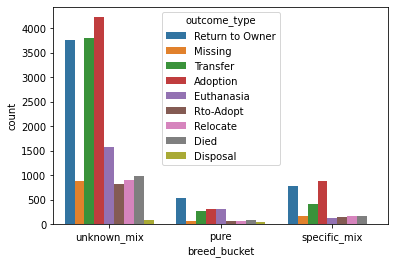

In [ ]:
sns.countplot(x= 'breed_bucket', hue="outcome_type", data= X)

This gives us an idea that that unknown mix bread type are either more adopted or transfered, pure bread type animal is either 

In [ ]:
#for the minority class
def adopt_conditions(df):
    if (df['outcome_type']=='Adoption'):      #made changes here removed !=Others
        return df['breed']
    
adoptable_dict = pd.DataFrame(X.apply(adopt_conditions, axis = 1), columns = ['adoptable_breeds'])
cleaned_adoptable_dict = adoptable_dict[adoptable_dict['adoptable_breeds'].notnull()]
cleaned_adoptable_dict = pd.DataFrame(cleaned_adoptable_dict['adoptable_breeds'].unique(), columns = ['unique_adoptable_breeds'])
adoptable_list = cleaned_adoptable_dict['unique_adoptable_breeds'].tolist()

In [ ]:
X[X['outcome_type']=='Rto-Adopt']

,dob_year,animal_type,breed,color,intake_condition,intake_type,sex_upon_intake,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter_days,sex_upon_outcome,age_upon_outcome_(days),outcome_month,outcome_monthyear,outcome_weekday,outcome_hour,outcome_type,intake_day,breed_bucket
41,2000,Cat,Domestic Longhair Mix,Black/White,Normal,Stray,Neutered Male,5110,10.0,2014.0,201410.0,Thursday,18.0,1.0,3.814583,Neutered Male,5110.0,10.0,201410.0,Monday,13.0,Rto-Adopt,16,unknown_mix
65,2002,Cat,Domestic Shorthair,Blue Cream/Tortie,Injured,Stray,Spayed Female,5475,4.0,2017.0,201704.0,Thursday,17.0,1.0,5.815278,Spayed Female,5475.0,4.0,201704.0,Wednesday,12.0,Rto-Adopt,20,pure
159,2004,Cat,Domestic Shorthair Mix,Silver Tabby,Normal,Stray,Spayed Female,4745,4.0,2017.0,201704.0,Thursday,16.0,1.0,11.830556,Spayed Female,4745.0,4.0,201704.0,Tuesday,12.0,Rto-Adopt,13,unknown_mix
216,2004,Dog,Miniature Poodle/Cairn Terrier,White/Cream,Normal,Stray,Neutered Male,4745,6.0,2017.0,201706.0,Sunday,17.0,2.0,5.062500,Neutered Male,4745.0,6.0,201706.0,Friday,18.0,Rto-Adopt,4,specific_mix
253,2003,Cat,Domestic Shorthair Mix,Black,Normal,Owner Surrender,Spayed Female,4380,11.0,2015.0,201511.0,Thursday,13.0,1.0,205.920139,Spayed Female,4380.0,6.0,201606.0,Sunday,11.0,Rto-Adopt,19,unknown_mix
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21449,2013,Dog,Flat Coat Retriever Mix,Black,Normal,Public Assist,Neutered Male,365,9.0,2014.0,201409.0,Saturday,11.0,1.0,18.322222,Neutered Male,365.0,10.0,201410.0,Wednesday,18.0,Rto-Adopt,13,unknown_mix
21463,2014,Cat,Domestic Shorthair,Tortie,Normal,Stray,Intact Female,30,9.0,2014.0,201409.0,Friday,11.0,1.0,14.006944,Spayed Female,60.0,9.0,201409.0,Friday,11.0,Rto-Adopt,12,pure
21471,2014,Cat,Domestic Shorthair Mix,Blue/White,Normal,Stray,Intact Male,7,9.0,2014.0,201409.0,Friday,11.0,1.0,0.177083,Intact Male,7.0,9.0,201409.0,Friday,15.0,Rto-Adopt,12,unknown_mix
21489,2014,Dog,Australian Cattle Dog/Pit Bull,Black/White,Normal,Stray,Intact Female,30,9.0,2014.0,201409.0,Friday,14.0,1.0,17.093056,Spayed Female,60.0,9.0,201409.0,Monday,16.0,Rto-Adopt,12,specific_mix


In [ ]:
#Trying to create some strengthing variable for the minority class
def rto_adopt_conditions(df):
    if (df['outcome_type']== 'Rto-Adopt'):      #made changes here removed !=Others
        return df['breed']
    
rto_adoptable_dict = pd.DataFrame(X.apply(rto_adopt_conditions, axis = 1), columns = ['rto_adoptable_breeds'])
rto_cleaned_adoptable_dict = rto_adoptable_dict[rto_adoptable_dict['rto_adoptable_breeds'].notnull()]
rto_cleaned_adoptable_dict = pd.DataFrame(rto_cleaned_adoptable_dict['rto_adoptable_breeds'].unique(), columns = ['unique_rto_adoptable_breeds'])
rto_adoptable_list = rto_cleaned_adoptable_dict['unique_rto_adoptable_breeds'].tolist()

In [ ]:
def disposal_conditions(df):
    if (df['outcome_type']=='Disposal'):
        return df['breed']
    
disposal_dict = pd.DataFrame(X.apply(disposal_conditions, axis = 1), columns = ['disposal_breeds'])
cleaned_disposal_dict = disposal_dict[disposal_dict['disposal_breeds'].notnull()]
cleaned_disposal_dict = pd.DataFrame(cleaned_disposal_dict['disposal_breeds'].unique(), columns = ['unique_disposal_breeds'])
disposal_list = cleaned_disposal_dict['unique_disposal_breeds'].tolist()

In [ ]:
disposal_list

['Bat Mix',
 'Raccoon',
 'Bat',
 'Raccoon Mix',
 'Fox',
 'Skunk Mix',
 'Squirrel',
 'Opossum Mix',
 'Domestic Shorthair Mix',
 'Skunk']

In [ ]:
def lookup_adotable_breeds(breed):
    if breed in adoptable_list:
        return 'adoptible_likely'          #made changes returns here
    else:
        return 'adoptible_unlikely'        #made changes returns here
    
def lookup_rto_adoptabale_breeds(breed):
    if breed in rto_adoptable_list:
        return 'rto_adoptible_likely'          #made changes returns here
    else:
        return 'rto_adoptible_unlikely'        #made changes returns here
        
def lookup_disposable_breeds(breed):
    if breed in disposal_list:
        return 'high_disposability'
    else:
        return 'low_disposability'

In [ ]:
X['adoptability'] = X.breed.apply(lookup_adotable_breeds)
X['disposability'] = X.breed.apply(lookup_disposable_breeds)
X['rto_adoptability']= X.breed.apply(lookup_rto_adoptabale_breeds)

In [ ]:
#We are excluding dogs because only 2 dogs are disposed.
X.loc[X['animal_type']=='Dog', 'disposability'] = 'low_disposability'

# Feature encoding(final iteration)

In [ ]:
X_final = X.copy()

In [ ]:
#FINAL ONE HOT ENCODING
def onehotdataframe_final(dfs):  
    one_hot_animal_type= pd.get_dummies(dfs.animal_type)

    one_hot_intake_condition = pd.get_dummies(dfs.intake_condition)
    one_hot_intake_condition.columns = [str(col) + '_intake' for col in one_hot_intake_condition.columns]

    one_hot_intake_type = pd.get_dummies(dfs.intake_type)
    one_hot_intake_type.columns = [str(col) + '_intake' for col in one_hot_intake_type.columns]

    one_hot_sex_upon_intake = pd.get_dummies(dfs.sex_upon_intake)
    one_hot_sex_upon_intake.columns = [str(col) + '_intake' for col in one_hot_sex_upon_intake.columns]

    one_hot_intake_weekday = pd.get_dummies(dfs.intake_weekday)
    one_hot_intake_weekday.columns = [str(col) + '_intake' for col in one_hot_intake_weekday.columns]

    one_hot_sex_upon_outcome = pd.get_dummies(dfs.sex_upon_outcome)
    one_hot_sex_upon_outcome.columns = [str(col) + '_outcome' for col in one_hot_sex_upon_outcome.columns]

    one_hot_outcome_weekday = pd.get_dummies(dfs.outcome_weekday)
    one_hot_outcome_weekday.columns = [str(col) + '_outcome' for col in one_hot_outcome_weekday.columns]     
    
    one_hot_breed_bucket = pd.get_dummies(dfs.breed_bucket)
    one_hot_breed_bucket.columns = [str(col) + '_breed_category' for col in one_hot_breed_bucket.columns]  
    
    dfs = dfs.drop(['animal_type','intake_type', 'intake_condition', 'sex_upon_intake', 'intake_weekday', 'sex_upon_outcome', 'outcome_weekday', 'breed_bucket'], axis = 1) 

    #Merging one hot encoded features with our dataset 'data' 
    df_encoded=pd.concat([dfs, one_hot_animal_type,one_hot_intake_condition,one_hot_intake_type,one_hot_sex_upon_intake,one_hot_intake_weekday,one_hot_sex_upon_outcome,one_hot_outcome_weekday, one_hot_breed_bucket],axis=1)  
    
    return(df_encoded)

In [ ]:
X_final = onehotdataframe_final(dfs = X_final)

In [ ]:
X_final

,dob_year,breed,color,age_upon_intake_(days),intake_month,intake_year,intake_monthyear,intake_hour,intake_number,time_in_shelter_days,age_upon_outcome_(days),outcome_month,outcome_monthyear,outcome_hour,outcome_type,intake_day,adoptability,disposability,rto_adoptability,Bird,Cat,Dog,Other,Aged_intake,Feral_intake,Injured_intake,Normal_intake,Nursing_intake,Other_intake,Pregnant_intake,Sick_intake,Euthanasia Request_intake,Owner Surrender_intake,Public Assist_intake,Stray_intake,Wildlife_intake,Intact Female_intake,Intact Male_intake,Neutered Male_intake,Spayed Female_intake,Unknown_intake,Friday_intake,Monday_intake,Saturday_intake,Sunday_intake,Thursday_intake,Tuesday_intake,Wednesday_intake,Intact Female_outcome,Intact Male_outcome,Neutered Male_outcome,Spayed Female_outcome,Unknown_outcome,Friday_outcome,Monday_outcome,Saturday_outcome,Sunday_outcome,Thursday_outcome,Tuesday_outcome,Wednesday_outcome,pure_breed_category,specific_mix_breed_category,unknown_mix_breed_category
0,2007,Spinone Italiano Mix,Yellow/White,3650,12.000000,2017.000000,201712.000000,14.000000,1.000000,0.588194,3650.000000,12.000000,201712.000000,0.000000,Return to Owner,7,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,2007,Spinone Italiano Mix,Yellow/White,2555,12.000000,2014.000000,201412.000000,10.000000,2.000000,1.259722,2555.000000,12.000000,201412.000000,16.000000,Return to Owner,19,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,2007,Spinone Italiano Mix,Yellow/White,2190,3.000000,2014.000000,201403.000000,14.000000,3.000000,1.113889,2190.000000,3.000000,201403.000000,17.000000,Return to Owner,7,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
3,2004,Dachshund,Tricolor,3650,4.000000,2014.000000,201404.000000,15.000000,1.000000,4.970139,3650.000000,4.000000,201404.000000,15.000000,Missing,2,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
4,1997,Shetland Sheepdog,Brown/White,5840,11.000000,2013.000000,201311.000000,9.000000,1.000000,0.119444,5840.000000,11.000000,201311.000000,11.000000,Return to Owner,16,adoptible_unlikely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21536,2009,Toy Poodle Mix,Apricot,1825,9.000000,2014.000000,201409.000000,11.000000,1.000000,9.070833,1825.000000,9.000000,201409.000000,13.000000,Return to Owner,13,adoptible_likely,low_disposability,rto_adoptible_unlikely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
21537,2012,Boxer Mix,Fawn/White,730,9.000000,2014.000000,201409.000000,14.000000,1.000000,1.142361,730.000000,9.000000,201409.000000,17.000000,Died,25,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
21538,2014,Labrador Retriever Mix,Brown,730,5.000000,2017.000000,201705.000000,11.000000,1.000000,0.143750,730.000000,5.000000,201705.000000,14.000000,Return to Owner,4,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
21539,2014,Labrador Retriever Mix,Brown,60,9.000000,2014.000000,201409.000000,11.000000,2.000000,4.279861,60.000000,9.000000,201409.000000,18.000000,Missing,13,adoptible_likely,low_disposability,rto_adoptible_likely,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0

In [ ]:
X_final['adoptability'] = X_final['adoptability'].map({'adoptible_unlikely' : 0, 'adoptible_likely' : 1 })
X_final['disposability'] = X_final['disposability'].map({'low_disposability' : 0, 'high_disposability' : 1 })
X_final['rto_adoptability'] = X_final['rto_adoptability'].map({'rto_adoptible_unlikely' : 0, 'rto_adoptible_likely' : 1 })

In [ ]:
X_final['outcome_type'] = X_final['outcome_type'].map({'Adoption' : 8, 'Transfer': 7, 'Return to Owner' : 6, 'Euthanasia' : 5, 'Died' : 4, 'Missing' : 3, 'Relocate' : 2, 'Rto-Adopt' : 1, 'Disposal' : 0})

In [ ]:
y_final = X_final['outcome_type']
X_final= X_final.drop(['outcome_type'], axis = 1)

In [ ]:
X_final_copy = X_final.copy()

In [ ]:
X_final_copy = X_final_copy.drop(['breed', 'color'], axis = 1)
X_final_copy['intake_monthyear'] = X_final_copy.intake_monthyear.astype(int)
X_final_copy['outcome_monthyear'] = X_final_copy.outcome_monthyear.astype(int)

** Dropping breed and color because i already tried to bucket these categorical features with "adoptablity","disposability" , "breed_bucket"**

In [ ]:
print(X_final_copy.shape, y_final.shape)

(21541, 60) (21541,)


In [ ]:
print('Missing value in training set:', X_final_copy.isnull().sum().max())

Missing value in training set: 0


** Converting into train and validation set **

In [ ]:
# Splitting the dataset into the Training set and Test set.
X_train, X_val, y_train, y_val = train_test_split(X_final_copy, y_final, test_size = 0.2, random_state = 20)
#Split is 80%-20% for testing. Here X_test~Validation set.


print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(17232, 60) (4309, 60) (17232,) (4309,)


In [ ]:
X_train['intake_monthyear'] = X_train.intake_monthyear.astype(int)
X_val['intake_monthyear'] = X_val.intake_monthyear.astype(int)
X_train['outcome_monthyear'] = X_train.outcome_monthyear.astype(int)
X_val['outcome_monthyear'] = X_val.outcome_monthyear.astype(int)

*italicized text*# TEST Xgboost
using XG boost for futher calc as it gave more accurate result before feature encoding

In [ ]:
model6 = XGBClassifier(learning_rate =0.1, n_estimators= 500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
model6.fit(X_train, y_train, eval_metric = 'mlogloss')

XGBClassifier(colsample_bytree=0.8, gamma=3, max_depth=7, n_estimators=500,
              nthread=4, objective='multi:softprob', seed=1234, subsample=0.8)

In [ ]:
y_pred2 = model6.predict(X_val)

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_pred2, y_val.iloc[:] , average = 'micro')
#(learning_rate =0.1,n_estimators= 1000,max_depth=5 ,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
#dropping color

0.6465537247621258

Improved XGboost score after feature engineering is 64.65

Observations:

1. Unknown_intake and unknown_outcome are same column hence dropping one, lets drop unknown_intake
2. Also dropping intake_year and Thursday_intake as they are poor predictors as expected. 

In [ ]:
X_train_final = X_train.drop(['Unknown_intake', 'intake_year', 'Thursday_intake'], axis = 1)
X_val_final = X_val.drop(['Unknown_intake' , 'intake_year', 'Thursday_intake'], axis = 1)

In [ ]:
model8 = XGBClassifier(learning_rate =0.1,n_estimators=500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=1, seed=1234)
model8.fit(X_train_final, y_train)
y_pred4 = model8.predict(X_val_final)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))

Thresh=0.005, n=57, Accuracy: 64.68%


# Predictions :

** Preparation of test set for predictions **

In [ ]:
test = pd.read_csv('/content/test.csv')

In [ ]:
test.shape

(31869, 36)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31869 entries, 0 to 31868
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dob_year                 31869 non-null  int64  
 1   animal_type              31869 non-null  object 
 2   breed                    31869 non-null  object 
 3   color                    31869 non-null  object 
 4   intake_condition         31869 non-null  object 
 5   intake_type              31869 non-null  object 
 6   sex_upon_intake          31869 non-null  object 
 7   age_upon_intake_(days)   31869 non-null  int64  
 8   intake_month             31869 non-null  int64  
 9   intake_year              31869 non-null  int64  
 10  intake_monthyear         31869 non-null  float64
 11  intake_weekday           31869 non-null  object 
 12  intake_hour              31869 non-null  int64  
 13  intake_number            31869 non-null  int64  
 14  time_in_shelter_days  

In [ ]:
test_final = test.copy()
test_final.shape

(31869, 26)

In [ ]:
test_final = onehotdataframe_final(dfs = test_final)

In [ ]:
test_final.shape

(31869, 62)

In [ ]:
test_final['adoptability'] = test_final['adoptability'].map({'adoptible_unlikely' : 0, 'adoptible_likely' : 1 })
test_final['disposability'] = test_final['disposability'].map({'low_disposability' : 0, 'high_disposability' : 1 })
test_final['rto_adoptability'] = test_final['rto_adoptability'].map({'rto_adoptible_unlikely' : 0, 'rto_adoptible_likely' : 1 })

In [ ]:
test_final = test_final.drop(['breed'], axis = 1)

In [ ]:
test_final = test_final.drop(['color'], axis = 1)

In [ ]:
#testing
test_final = test_final.drop(['Unknown_intake', 'intake_year', 'Thursday_intake'], axis = 1)

In [ ]:
#test_final = test_final.drop(['intake_monthyear'], axis = 1)

In [ ]:
test_final.shape

(31869, 57)

** Below are iterative models that I used to check the performance of my different models on out of time validation set(i.e. test set) and select models accordingly **

In [ ]:
#Testing subject to changes
X_train_final_check = X_train_final.drop(['intake_monthyear'], axis = 1)
X_val_final_check = X_val_final.drop(['intake_monthyear'], axis = 1)


In [ ]:
#Including intake_monthyear
model5 = lgb(task = 'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  -1, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2500, random_state =1234,min_split_gain = 0, reg_alpha = 0, reg_lambda = 0 ) 
model5.fit(X_train_final, y_train)
y_pred4 = model5.predict(X_val_final)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

TypeError: ignored

In [ ]:
model5 = lgb(task = 'train',boosting_type =  'gbdt',  objective = 'multiclass',num_class = 9,metric = 'multi_logloss',learning_rate =  0.0026, max_depth=  -1, num_leaves =  64, feature_fraction =  0.4, bagging_fraction =  0.6, bagging_freq =  17, n_estimators = 2500, random_state =1234,min_split_gain = 0, reg_alpha = 0, reg_lambda = 0 ) 
model5.fit(X_train_final_check, y_train)
y_pred4 = model5.predict(X_val_final_check)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final_check.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

TypeError: ignored

In [ ]:
print('Missing value in training set:', X_train_final_check.isnull().sum().max())

Missing value in training set: 0


In [ ]:
#Excluding intake_monthyear
rf =  RandomForestClassifier(n_estimators= 1000 , criterion = 'entropy' , random_state = 0, bootstrap = True)
rf.fit(X_train_final_check, y_train)
y_pred4 = rf.predict(X_val_final_check)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 62.68%
f1 -score :  0.6268275702019029


In [ ]:
#Including intake_monthyear
xgb = XGBClassifier(learning_rate =0.1, n_estimators= 500,max_depth= 7 ,min_child_weight=1, gamma=3, subsample=0.8, colsample_bytree=0.8,objective= 'multi:softmax',nthread=4, scale_pos_weight=99, seed=1234)
xgb.fit(X_train_final, y_train, eval_metric = 'mlogloss')
y_pred4 = xgb.predict(X_val_final)
predictions = [round(value) for value in y_pred4]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred4, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

Thresh=0.005, n=57, Accuracy: 64.68%
f1 -score :  0.6467857971687166


Hence we will keep the intake_monthyear variable

In [ ]:
estimators =[]
model1= model5
estimators.append(('lightgbm', model1))
model2=rf
estimators.append(('random_forest', model2))
model3=xgb
estimators.append(('xgboost', model3))
'''Ensembling now'''
ensemble = VotingClassifier(estimators, voting = 'soft', weights = [2,1,2]) 
ensemble.fit(X_train_final, y_train)

NameError: ignored

In [ ]:
y_pred_ensemble = ensemble.predict(X_val_final)
predictions = [round(value) for value in y_pred_ensemble]
accuracy = accuracy_score(y_val, predictions)
f_score = f1_score(y_pred_ensemble, y_val.iloc[:] , average = 'micro')
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (0.0048, X_train_final.shape[1], accuracy*100.0))
print("f1 -score : ",f_score )

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred_ensemble, y_val)

NameError: ignored

In [ ]:
from sklearn.metrics import roc_auc_score
sns.heatmap(cm,annot=True,fmt="d", cbar = False)
print(classification_report(y_pred_ensemble, y_val))

In [ ]:
final_predict1 = model8.predict(test_final)

In [ ]:
f_score = f1_score(final_predict1, test_final.iloc[:] , average = 'micro')
print("f1 -score : ",f_score )

ValueError: ignored

In [ ]:
predictions = pd.DataFrame(ml_dataset_test['animal_id_outcome'])
y_pred_df = pd.DataFrame(final_predict1, columns=['outcome_type'])
results = pd.concat([predictions, y_pred_df], axis=1)
results['outcome_type']= results['outcome_type'].map({ 8 :'Adoption', 7: 'Transfer', 6: 'Return to Owner', 5 : 'Euthanasia' , 4 : 'Died' , 3 : 'Missing' , 2 : 'Relocate' ,  1 : 'Rto-Adopt' , 0 : 'Disposal' }).astype(str)

In [ ]:
results.to_csv('/content/aac_shelter_outcomes.csv', index = False)

**Final results:**

Best Model: XGBoost ( after feature engineering

Best F1_score for training set :64.68